In [2103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "data"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
%matplotlib inline
import statistics
from fuzzywuzzy import fuzz
import nltk.tokenize as nt
import nltk
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2104]:
def remove_outliers(df):
    # standard deviation threshold
    sd_threshold = 1
    
    # Remove price outliers
    df = df[(df.price <= 15000) & (df.price >= 1000)]
    
    # Remove dist from city centre outliers
    # apporimate radius from city centre
    NYC_RADIUS = 20
    df = df[(df.dist_from_ctr <= 20)]
    return df

In [2105]:
manager_scores = {}
def create_manager_scores(df):
    global manager_scores
    manager_scores = {}
    
    def calculate_manager_score(row):
        manager_id = row['manager_id']
        interest = row['interest_level']
        
        score_to_add = 0
        if interest == 'high':
            score_to_add += 3
        elif interest == 'medium':
            score_to_add += 2
        elif interest == 'low':
            score_to_add += 1
        
        if manager_id in manager_scores:
            manager_scores[manager_id].append(score_to_add)
        else:
            manager_scores[manager_id] = [score_to_add]
    df.apply(calculate_manager_score, axis=1)

def apply_manager_scores(row):
    manager_id = row['manager_id']
    
    if manager_id in manager_scores:
        row['manager_score'] = sum(manager_scores[manager_id])/len(manager_scores[manager_id])
    else:
        row['manager_score'] = 0
        
    return row



In [2106]:
building_scores = {}
def create_building_scores(df):
    global building_scores
    building_scores = {}
    
    def calculate_building_score(row):
        building_id = row['building_id']
        interest = row['interest_level']
        
        score_to_add = 0
        if interest == 'high':
            score_to_add += 3
        elif interest == 'medium':
            score_to_add += 2
        elif interest == 'low':
            score_to_add += 1
        
        if building_id in building_scores:
            building_scores[building_id].append(score_to_add)
        else:
            building_scores[building_id] = [score_to_add]
        
    df.apply(calculate_building_score, axis=1)
    
    # NOTE : Building ID '0' seem to be missing data issue | Assigning 0 score to building id 0   
    building_scores['0'] = [0]
    
def apply_building_scores(row):
    building_id = row['building_id']
    if building_id in building_scores:
        row['building_score'] = sum(building_scores[building_id])/len(building_scores[building_id])
    else:
        row['building_score'] = 0
        
    return row

In [2107]:
def price_per_bedroom(row):
    bedrooms = row['bedrooms']
    if bedrooms == 0:
        price_per_bedroom = 0
    else:
        price_per_bedroom = row['price'] * 1.00 / bedrooms
    row['price_per_bedroom'] = price_per_bedroom
    return row

In [2108]:
def price_per_bathroom(row):
    bathrooms = row['bathrooms']
    if bathrooms == 0:
        price_per_bathroom = 0
    else:
        price_per_bathroom = row['price'] * 1.00 / bathrooms
    row['price_per_bathroom'] = price_per_bathroom
    return row

In [2109]:
def price_per_total_room(row):
    rooms = row['total_rooms']
    if rooms == 0:
        price_per_total_rooms = 0
    else:
        price_per_total_rooms = row['price'] * 1.00 / rooms
    row['price_per_total_rooms'] = price_per_total_rooms
    return row

In [2110]:
def bath_bed_ratio(row):
    bedrooms = row['bedrooms']
    bathrooms = row['bathrooms']
    if bedrooms == 0:
        bath_bed_ratio = bathrooms
    else:
        bath_bed_ratio = bathrooms/bedrooms
    
    row['bath_bed_ratio'] = bath_bed_ratio
    return row

In [2111]:
# Key : Feature in data | Value : column name to be created for category variable

home_features_dict = {'Elevator': 'has_elevator',
 'Cats Allowed': 'has_cats_allowed',
 'Hardwood Floors': 'has_hardwood_floors',
 'Dogs Allowed': 'has_dogs_allowed',
 'Doorman': 'has_doorman',
 'Dishwasher': 'has_dishwasher',
 'No Fee': 'has_no_fee',
 'Laundry in Building': 'has_laundry_in_building',
 'Fitness Center': 'has_fitness_center',
 'Pre-War': 'has_pre-war',
 'Laundry in Unit': 'has_laundry_in_unit',
 'Roof Deck': 'has_roof_deck',
 'Outdoor Space': 'has_outdoor_space',
 'Dining Room': 'has_dining_room',
 'High Speed Internet': 'has_high_speed_internet',
 'Balcony': 'has_balcony',
 'Swimming Pool': 'has_swimming_pool',
 'Laundry In Building': 'has_laundry_in_building',
 'New Construction': 'has_new_construction',
 'Terrace': 'has_terrace',
 'Exclusive': 'has_exclusive',
 'Loft': 'has_loft',
 'Garden/Patio': 'has_garden/patio',
 'Wheelchair Access': 'has_wheelchair_access',
 'Common Outdoor Space': 'has_common_outdoor_space'}

def process_home_features(df):
    # Add columns for popular features
    for key, val in home_features_dict.items():
        df[val] = 0
        
    def update_popular_feature_cols(row):
        features = row['features']
        for feature in features:
            if feature in home_features_dict:
                row[home_features_dict[feature]] = 1

        return row
    
    df = df.apply(update_popular_feature_cols, axis=1)
    return df

In [2112]:
def create_has_photos_has_description(row):
    row['has_photos'] = 1 if row['num_photos'] > 0 else 0
    row['has_description'] = 1 if row['num_description_words'] > 0 else 0
    return row

In [2113]:
import geopy.distance
def distance_from_centre(row):
    centre = (40.718, -74.008)
    lat_long = (row['latitude'], row['longitude'])
    distance = geopy.distance.geodesic(centre, lat_long).miles
    row['dist_from_ctr'] = distance
    return row

In [2114]:
def street_and_display_address_similarity(row):
    street_ad = row['street_address'].lower()
    display_ad = row['display_address'].lower()
    row['address_similarity'] = 0 if (fuzz.ratio(street_ad, display_ad)/100) <= 0.5 else 1
    return row

In [2115]:
def get_num_adjectives(text):
    if not text:
        return 0
    ss=nt.sent_tokenize(text)
    tokenized_sent=[nt.word_tokenize(sent) for sent in ss]
    pos_sentences=[nltk.pos_tag(sent) for sent in tokenized_sent]
    pos_sentences
    adjectives = 0
    for pos in pos_sentences:
        for pair in pos:
            tag = pair[1]
            if tag in ['JJ', 'JJR', 'JJS']:
                adjectives += 1

    return adjectives

In [2116]:
def add_adjectives_column(row):
    description = row["description"]
    row['num_adjectives_description'] = get_num_adjectives(description)
    return row

In [2117]:
def bucket_hour(hour):
    if hour > 4 and hour <= 10:
        return 'morning'
    elif hour > 10 and hour <= 16:
        return 'noon'
    elif hour > 16 and hour <= 22:
        return 'evening'
    else:
        return 'night'

### One hot encoder

In [2118]:
cat_dummies = set()
def one_hot_encode(df, cols):
    # Get one hot encoding of column
    df_processed = pd.get_dummies(df, prefix_sep="__",
                              columns=cols)
    # save all categorical variables
    global cat_dummies
    cat_dummies = set([col for col in df_processed 
               if "__" in col 
               and col.split("__")[0] in cols])
    
    return df_processed

## Feature Engineering

In [2119]:
def feature_engineering(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))

    # Create date month year
    df["created"] = pd.to_datetime(df["created"])
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour
    df["created_day_of_week"] = df["created"].dt.dayofweek
    df["created_day_of_month"] = df["created"].dt.day
    df['is_weekday'] = ((df.created_day_of_week) // 5 == 1).astype(float)
    df = df.apply(apply_manager_scores, axis=1)
    df = df.apply(price_per_bedroom, axis=1)
    df = process_home_features(df)
    df = df.apply(distance_from_centre, axis=1)
    
    # if length is more than 2 - has address
    df['has_display_address'] = df['display_address'].apply(lambda x : 1 if len(x) > 2 else 0)
    df['has_street_address'] = df['street_address'].apply(lambda x : 1 if len(x) > 2 else 0)
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df = df.apply(price_per_total_room, axis=1)
    df = df.apply(apply_building_scores, axis=1)
    
    # One hot encodings
    df = one_hot_encode(df, ['created_hour', 'created_month'])
    # Didn't work
    # df = df.apply(create_has_photos_has_description, axis=1)
    # df = df.apply(price_per_bathroom, axis=1) 
    # df = df.apply(bath_bed_ratio, axis=1)
    # df["bed_bath_differnce"] = df['bedrooms'] - df['bathrooms']
    # df["bed_bath_sum"] = df["bedrooms"] + df['bathrooms']
    return df

In [2127]:
# num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
    #              "num_photos", "num_features", "num_description_words",
    #              "created_year", "created_month", "created_day"]
def get_feature_list():
    num_feats = ["bathrooms", 
             "bedrooms", 
             "latitude", 
             "longitude", 
             "price",
             "num_photos", 
             "num_features", 
             "num_description_words",
             "created_day_of_month",
             "is_weekday",
             "manager_score",
#              "building_score",
#              "price_per_bedroom",
             "dist_from_ctr",
             "has_display_address", 
             "has_street_address",
             "total_rooms",
             "price_per_total_rooms"
#              "num_adjectives_description"
            ]
    
    # Add one hot encoded variables
    global cat_dummies
    num_feats.extend(cat_dummies)
    
    # add names of house features
    num_feats.extend(list(home_features_dict.values()))
    pprint(f'Features : {num_feats}')
    return num_feats

### Read Data

In [2121]:
df = pd.read_json(open("data/train.json", "r"))
print(df.shape)
df.describe()

(49352, 15)


,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Remove Outliers

In [2122]:
create_manager_scores(df)
create_building_scores(df)

In [2123]:
df = feature_engineering(df)

/Users/vipul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [2124]:
df['building_score'].describe()

count    49352.000000
mean         1.197115
std          0.654693
min          0.000000
25%          1.000000
50%          1.272109
75%          1.500000
max          3.000000
Name: building_score, dtype: float64

In [2125]:
scaler = StandardScaler()
df.shape

(49352, 81)

### Train Model

In [2128]:
# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

X = df[get_feature_list()]
y = df["interest_level"]
X.head()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)


clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)

# calculate training loss
loss = log_loss(y_val, y_val_pred)
print(f'Loss : {loss}')

("Features : ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', "
 "'num_photos', 'num_features', 'num_description_words', "
 "'created_day_of_month', 'is_weekday', 'manager_score', 'dist_from_ctr', "
 "'has_display_address', 'has_street_address', 'total_rooms', "
 "'price_per_total_rooms', 'created_month__5', 'created_hour__1', "
 "'created_hour__2', 'created_hour__8', 'created_hour__23', "
 "'created_hour__19', 'created_hour__0', 'created_hour__9', "
 "'created_hour__12', 'created_hour__3', 'created_hour__21', "
 "'created_hour__4', 'created_hour__5', 'created_hour__22', "
 "'created_hour__10', 'created_month__4', 'created_hour__13', "
 "'created_hour__16', 'created_hour__20', 'created_hour__11', "
 "'created_hour__17', 'created_hour__18', 'created_hour__6', "
 "'created_hour__14', 'created_month__6', 'created_hour__15', "
 "'created_hour__7', 'has_elevator', 'has_cats_allowed', "
 "'has_hardwood_floors', 'has_dogs_allowed', 'has_doorman', 'has_dishwasher', "
 "'has_no_fee',

("Features : ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', "
 "'num_photos', 'num_features', 'num_description_words', "
 "'created_day_of_month', 'is_weekday', 'manager_score', 'dist_from_ctr', "
 "'has_display_address', 'has_street_address', 'total_rooms', "
 "'price_per_total_rooms', 'created_month__5', 'created_hour__1', "
 "'created_hour__2', 'created_hour__8', 'created_hour__23', "
 "'created_hour__19', 'created_hour__0', 'created_hour__9', "
 "'created_hour__12', 'created_hour__3', 'created_hour__21', "
 "'created_hour__4', 'created_hour__5', 'created_hour__22', "
 "'created_hour__10', 'created_month__4', 'created_hour__13', "
 "'created_hour__16', 'created_hour__20', 'created_hour__11', "
 "'created_hour__17', 'created_hour__18', 'created_hour__6', "
 "'created_hour__14', 'created_month__6', 'created_hour__15', "
 "'created_hour__7', 'has_elevator', 'has_cats_allowed', "
 "'has_hardwood_floors', 'has_dogs_allowed', 'has_doorman', 'has_dishwasher', "
 "'has_no_fee',

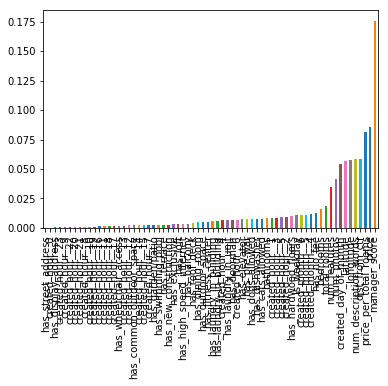

In [2130]:
pd.Series(index = get_feature_list(), data = clf.feature_importances_).sort_values().plot(kind = 'bar')

In [ ]:
X.shape

## Making predictions on test data

### Read and feature engineer

In [2131]:
test_df = pd.read_json(open("data/test.json", "r"))
test_df = feature_engineering(test_df)

/Users/vipul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [2138]:
test_df[get_feature_list()].describe()

("Features : ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', "
 "'num_photos', 'num_features', 'num_description_words', "
 "'created_day_of_month', 'is_weekday', 'manager_score', 'dist_from_ctr', "
 "'has_display_address', 'has_street_address', 'total_rooms', "
 "'price_per_total_rooms', 'created_month__5', 'created_hour__1', "
 "'created_hour__2', 'created_hour__8', 'created_hour__23', "
 "'created_hour__19', 'created_hour__0', 'created_hour__9', "
 "'created_hour__12', 'created_hour__3', 'created_hour__21', "
 "'created_hour__4', 'created_hour__5', 'created_hour__22', "
 "'created_hour__10', 'created_month__4', 'created_hour__13', "
 "'created_hour__16', 'created_hour__20', 'created_hour__11', "
 "'created_hour__17', 'created_hour__18', 'created_hour__6', "
 "'created_hour__14', 'created_month__6', 'created_hour__15', "
 "'created_hour__7', 'has_elevator', 'has_cats_allowed', "
 "'has_hardwood_floors', 'has_dogs_allowed', 'has_doorman', 'has_dishwasher', "
 "'has_no_fee',

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_day_of_month,is_weekday,...,has_balcony,has_swimming_pool,has_laundry_in_building,has_new_construction,has_terrace,has_exclusive,has_loft,has_garden/patio,has_wheelchair_access,has_common_outdoor_space
count,74659.000000,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,...,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000
mean,1.212915,1.544663,40.735060,-73.945282,3.749033e+03,5.620193,5.423593,90.093050,15.151623,0.235819,...,0.062243,0.059229,0.375842,0.050992,0.045098,0.044241,0.042647,0.039526,0.027257,0.026802
std,0.649820,1.107014,0.806687,1.487795,9.713092e+03,3.641383,3.917167,60.771831,8.245418,0.424512,...,0.241598,0.236055,0.484343,0.219983,0.207521,0.205632,0.202062,0.194845,0.162833,0.161505
min,0.000000,0.000000,0.000000,-121.488000,1.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,40.727800,-73.991800,2.495000e+03,4.000000,2.000000,50.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.751600,-73.977700,3.150000e+03,5.000000,5.000000,83.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,40.774300,-73.954700,4.100000e+03,7.000000,8.000000,119.000000,22.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,112.000000,7.000000,42.872700,0.000000,1.675000e+06,50.000000,36.000000,2837.000000,31.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Predict

In [2133]:
X_test = test_df[get_feature_list()]
X_test = scaler.transform(X_test)
y = clf.predict_proba(X_test)

labels2idx = {label: i for i, label in enumerate(clf.classes_)}

sub = pd.DataFrame()
sub["listing_id"] = test_df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]

("Features : ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', "
 "'num_photos', 'num_features', 'num_description_words', "
 "'created_day_of_month', 'is_weekday', 'manager_score', 'dist_from_ctr', "
 "'has_display_address', 'has_street_address', 'total_rooms', "
 "'price_per_total_rooms', 'created_month__5', 'created_hour__1', "
 "'created_hour__2', 'created_hour__8', 'created_hour__23', "
 "'created_hour__19', 'created_hour__0', 'created_hour__9', "
 "'created_hour__12', 'created_hour__3', 'created_hour__21', "
 "'created_hour__4', 'created_hour__5', 'created_hour__22', "
 "'created_hour__10', 'created_month__4', 'created_hour__13', "
 "'created_hour__16', 'created_hour__20', 'created_hour__11', "
 "'created_hour__17', 'created_hour__18', 'created_hour__6', "
 "'created_hour__14', 'created_month__6', 'created_hour__15', "
 "'created_hour__7', 'has_elevator', 'has_cats_allowed', "
 "'has_hardwood_floors', 'has_dogs_allowed', 'has_doorman', 'has_dishwasher', "
 "'has_no_fee',

In [2134]:
sub.to_csv("submission_rf.csv", index=False)

In [2135]:
submission = pd.read_csv('submission_rf.csv')

In [2136]:
submission.head()

,listing_id,high,medium,low
0,7142618,0.073,0.456,0.471
1,7210040,0.041,0.131,0.828
2,7103890,0.084,0.430,0.486
3,7143442,0.157,0.456,0.387
4,6860601,0.023,0.224,0.753


("Features : ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', "
 "'num_photos', 'num_features', 'num_description_words', "
 "'created_day_of_month', 'is_weekday', 'manager_score', 'dist_from_ctr', "
 "'has_display_address', 'has_street_address', 'total_rooms', "
 "'price_per_total_rooms', 'created_month__5', 'created_hour__1', "
 "'created_hour__2', 'created_hour__8', 'created_hour__23', "
 "'created_hour__19', 'created_hour__0', 'created_hour__9', "
 "'created_hour__12', 'created_hour__3', 'created_hour__21', "
 "'created_hour__4', 'created_hour__5', 'created_hour__22', "
 "'created_hour__10', 'created_month__4', 'created_hour__13', "
 "'created_hour__16', 'created_hour__20', 'created_hour__11', "
 "'created_hour__17', 'created_hour__18', 'created_hour__6', "
 "'created_hour__14', 'created_month__6', 'created_hour__15', "
 "'created_hour__7', 'has_elevator', 'has_cats_allowed', "
 "'has_hardwood_floors', 'has_dogs_allowed', 'has_doorman', 'has_dishwasher', "
 "'has_no_fee',

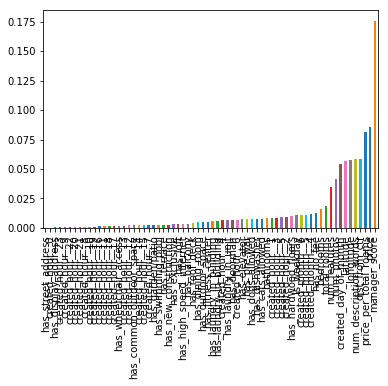

In [2139]:
pd.Series(index = get_feature_list(), data = clf.feature_importances_).sort_values().plot(kind = 'bar')

## XGB

In [2140]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [2141]:
# X = test_df[num_feats]
# X = scaler.transform(X)

In [2142]:
target_num_map = {'high':0, 'medium':1, 'low':2}
y = np.array(df['interest_level'].apply(lambda x: target_num_map[x]))

preds, model = runXGB(X, y, X_test, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter.csv", index=False)

In [2143]:
X.shape

(49352, 68)

In [2144]:
y_train.shape

(39481,)

In [2145]:
df[num_feats].shape

KeyError: "['created_year'] not in index"